## Imports

In [53]:
# =========================
# Cell 1: Imports & setup
# =========================
import os, re, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from pathlib import Path
from datetime import datetime

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, label_binarize
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    f1_score, accuracy_score, roc_auc_score, confusion_matrix, RocCurveDisplay,
    ConfusionMatrixDisplay, classification_report
)
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier

import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
rng = np.random.default_rng(42)

# Try XGBoost; if unavailable, fall back to HistGradientBoosting (sklearn)
HAS_XGB = False
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False

# ---- Paths
BASE = Path(".")
DATA_CORE = Path("../data/processed/data_core.csv")
OUT_DIR = Path("../data/processed/ProblemB")
OUT_DIR.mkdir(parents=True, exist_ok=True)

SEED = 42

print(f"Use XGBoost: {HAS_XGB}")
print("Paths OK:", DATA_CORE.exists(), OUT_DIR.exists())

Use XGBoost: True
Paths OK: True True


## Load & Parse DATE / MODEL from source_file (Save as enriched)

In [54]:
# ======================================
# Cell 2: Load data & parse meta fields
# ======================================
df = pd.read_csv(DATA_CORE)

# ---- find the source_file column (case-insensitive)
def find_source_col(columns):
    cand = [c for c in columns if "source" in c.lower() and "file" in c.lower()]
    if cand:
        return cand[0]
    # fallback guesses
    for key in ["source_file", "file", "filename", "path"]:
        if key in [c.lower() for c in columns]:
            return [c for c in columns if c.lower() == key][0]
    raise ValueError("Cannot locate source_file column. Please ensure it exists.")

SRC_COL = find_source_col(df.columns)
print("Detected source column:", SRC_COL)

# ---- parse DATE from leading digits in basename (e.g., 180119 -> 2018-01-19)
def parse_date_from_source(s):
    base = os.path.basename(str(s))
    # take the first continuous digit block at start
    m = re.match(r"^(\d{6,8})", base.replace("_","").replace("-",""))
    if not m:
        return pd.NaT
    token = m.group(1)
    try:
        if len(token) == 8:        # YYYYMMDD
            dt = datetime.strptime(token, "%Y%m%d")
        elif len(token) == 6:      # YYMMDD -> 20YYMMDD
            dt = datetime.strptime("20"+token, "%Y%m%d")
        else:
            return pd.NaT
        return dt.date()
    except Exception:
        return pd.NaT

# ---- parse MODEL from filename tokens (case-insensitive)
def parse_model_from_source(s):
    s_low = str(s).lower()
    if "elf5" in s_low:
        return "ELF5"
    if "k5" in s_low:
        return "K5"
    # include prhugo, etc. -> PR
    if "pr" in s_low:
        return "PR"
    return "UNKNOWN"

# If CHANNEL not present, try to parse; else keep existing
if "CHANNEL" not in df.columns:
    def parse_channel_from_source(s):
        s_low = str(s).lower()
        for ch in ["yfp", "rfp", "cfp"]:
            if ch in s_low:
                return ch.upper()
        return None
    df["CHANNEL"] = df[SRC_COL].map(parse_channel_from_source)

# Create meta columns (do not use as features later)
df["META_DATE"]  = df[SRC_COL].map(parse_date_from_source)
df["META_MODEL"] = df[SRC_COL].map(parse_model_from_source)

# Basic cleaning: drop UNKNOWN model rows (rare)
before = len(df)
df = df[df["META_MODEL"].isin(["K5","ELF5","PR"])].copy()
after = len(df)
print(f"Dropped UNKNOWN model rows: {before - after}")

# Save enriched copy for traceability
enriched_path = OUT_DIR / "data_core_with_meta.csv"
df.to_csv(enriched_path, index=False)
print("Saved:", enriched_path)
df = df.drop(columns=["Channel"])
# quick peek
display_cols = [SRC_COL, "CHANNEL", "META_MODEL", "META_DATE"]
print(df[display_cols].head(8))


Detected source column: SOURCE_FILE
Dropped UNKNOWN model rows: 0
Saved: ..\data\processed\ProblemB\data_core_with_meta.csv
                     SOURCE_FILE CHANNEL META_MODEL   META_DATE
0  160727_k5_CFP_16-32_spots.csv     CFP         K5  2016-07-27
1  160727_k5_CFP_16-32_spots.csv     CFP         K5  2016-07-27
2  160727_k5_CFP_16-32_spots.csv     CFP         K5  2016-07-27
3  160727_k5_CFP_16-32_spots.csv     CFP         K5  2016-07-27
4  160727_k5_CFP_16-32_spots.csv     CFP         K5  2016-07-27
5  160727_k5_CFP_16-32_spots.csv     CFP         K5  2016-07-27
6  160727_k5_CFP_16-32_spots.csv     CFP         K5  2016-07-27
7  160727_k5_CFP_16-32_spots.csv     CFP         K5  2016-07-27


In [55]:
df.head()

,LABEL,ID,TRACK_ID,QUALITY,POSITION_X,POSITION_Y,POSITION_T,FRAME,RADIUS,VISIBILITY,...,ELLIPSE_ASPECTRATIO,AREA,PERIMETER,CIRCULARITY,SOLIDITY,SHAPE_INDEX,SOURCE_FILE,CHANNEL,META_DATE,META_MODEL
0,ID2945,2945,0,209.0,145.948467,95.621082,3.0,3,8.110457,1,...,1.401931,206.652412,71.594489,0.506630,0.853061,4.980344,160727_k5_CFP_16-32_spots.csv,CFP,2016-07-27,K5
1,ID2946,2946,0,220.0,148.047821,94.433312,7.0,7,8.321153,1,...,2.316572,217.528855,89.493111,0.341309,0.810313,6.067799,160727_k5_CFP_16-32_spots.csv,CFP,2016-07-27,K5
2,ID2947,2947,0,195.0,145.259303,91.481847,11.0,11,7.834106,1,...,2.432088,192.809667,89.493111,0.302524,0.799180,6.445034,160727_k5_CFP_16-32_spots.csv,CFP,2016-07-27,K5
3,ID2948,2948,0,234.0,145.152217,91.656074,21.0,21,8.581834,1,...,1.992784,231.371600,85.515639,0.397584,0.855576,5.621996,160727_k5_CFP_16-32_spots.csv,CFP,2016-07-27,K5
4,ID2951,2951,0,219.0,143.997185,89.188898,12.0,12,8.302220,1,...,2.747553,216.540087,99.436790,0.275204,0.773852,6.757374,160727_k5_CFP_16-32_spots.csv,CFP,2016-07-27,K5


## Helpers: dataset builder, splitters, model zoo, metrics

In [ ]:
# =======================================================
# Cell 3: Utilities — dataset maker, splitters, models
# =======================================================
from typing import Dict, List, Tuple


LEAKY_COLS = {
    "MODEL", "LABEL", "TARGET", "META_MODEL", "META_DATE",
    "DATE", "FrameStart", "FrameEnd", "FrameRange", SRC_COL
}

LEAKY_COLS |= set([c for c in df.columns if "region" in c.lower() or "id" in c.lower()])

def get_numeric_feature_cols(frame: pd.DataFrame) -> List[str]:
    num_cols = frame.select_dtypes(include=[np.number]).columns.tolist()
    # remove leaky columns if accidentally numeric
    num_cols = [c for c in num_cols if c not in LEAKY_COLS and c.upper() != "CHANNEL"]
    return num_cols

def make_dataset_single_channel(frame: pd.DataFrame, channel="YFP") -> Tuple[pd.DataFrame, pd.Series, pd.Series, List[str], List[str]]:
    sub = frame.copy()
    sub = sub[sub["CHANNEL"].str.upper() == channel.upper()].copy()
    numeric_cols = get_numeric_feature_cols(sub)
    X = sub[numeric_cols].copy()
    y = sub["META_MODEL"].copy()
    groups = pd.to_datetime(sub["META_DATE"]).dt.date
    cat_cols = [] 
    print(f"[Single-Channel={channel}] shape={X.shape}, models={y.value_counts().to_dict()}, dates={len(pd.unique(groups))}")
    return X, y, groups, numeric_cols, cat_cols

def make_dataset_multi_channel(frame: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series, pd.Series, List[str], List[str]]:
    sub = frame.copy()
    numeric_cols = get_numeric_feature_cols(sub)
    used_cols = numeric_cols + ["CHANNEL"]
    X = sub[used_cols].copy()
    y = sub["META_MODEL"].copy()
    groups = pd.to_datetime(sub["META_DATE"]).dt.date
    cat_cols = ["CHANNEL"]
    print(f"[Multi-Channel] shape={X.shape}, models={y.value_counts().to_dict()}, dates={len(pd.unique(groups))}")
    return X, y, groups, numeric_cols, cat_cols

def make_outer_splitter(groups, n_splits=5):
    n_unique = len(pd.unique(groups))
    if n_unique >= n_splits:
        return GroupKFold(n_splits=n_splits)
    else:
        print(f"Not enough unique dates ({n_unique}) for {n_splits}-fold; using LeaveOneGroupOut.")
        return LeaveOneGroupOut()

def build_preprocessor(numeric_cols, cat_cols=None, for_linear=True):
    cat_cols = cat_cols or []
    num_pipeline = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()) if for_linear else ("passthrough", "passthrough")
    ])
    transformers = [("num", num_pipeline, numeric_cols)]
    if len(cat_cols) > 0:
        transformers.append(("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols))
    pre = ColumnTransformer(transformers=transformers, remainder="drop", sparse_threshold=0.0)
    return pre

from sklearn.multiclass import OneVsRestClassifier

def get_model_spaces(for_multi_channel=False):
    # Logistic
    lr = LogisticRegression(
        penalty="l2", solver="saga", max_iter=2000,
        random_state=SEED, multi_class="multinomial"
    )
    lr_space = {
        "model__C": np.logspace(-3, 3, 13),
        "model__class_weight": [None, "balanced"]
    }

    # Random Forest
    rf = RandomForestClassifier(
        n_estimators=400, random_state=SEED, n_jobs=-1
    )
    rf_space = {
        "model__n_estimators": [200, 400, 800],
        "model__max_depth": [None, 6, 10, 16],
        "model__min_samples_leaf": [1, 2, 5],
        "model__max_features": ["sqrt", "log2", 0.5],
        "model__class_weight": [None, "balanced"]
    }

    # —— XGBoost to One-vs-Rest——
    if HAS_XGB:
        base = XGBClassifier(
            objective="binary:logistic", eval_metric="logloss",
            tree_method="hist", random_state=SEED, n_estimators=400, verbosity=0
        )
        xgb_ovr = OneVsRestClassifier(base, n_jobs=-1)
        xgb_space = {
           
            "model__estimator__n_estimators": [200, 400, 800],
            "model__estimator__learning_rate": [0.02, 0.05, 0.1, 0.2],
            "model__estimator__max_depth": [3, 5, 7],
            "model__estimator__subsample": [0.7, 0.9, 1.0],
            "model__estimator__colsample_bytree": [0.7, 0.9, 1.0],
            "model__estimator__reg_lambda": [0, 1, 5, 10],
            "model__estimator__reg_alpha": [0, 0.5, 1.0]
        }
        gbm = xgb_ovr
        gbm_space = xgb_space
        gbm_name = "XGB-OVR"
    else:
        from sklearn.ensemble import HistGradientBoostingClassifier
        hgb = HistGradientBoostingClassifier(random_state=SEED)
        gbm = hgb
        gbm_space = {
            "model__max_depth": [None, 6, 10],
            "model__learning_rate": [0.02, 0.05, 0.1],
            "model__max_leaf_nodes": [31, 63, 127],
            "model__l2_regularization": [0.0, 0.1, 1.0]
        }
        gbm_name = "HGB"

    return {
        "LR": (lr, lr_space, True),
        "RF": (rf, rf_space, False),
        gbm_name: (gbm, gbm_space, False)
    }

def evaluate_fold(y_true, y_pred, y_proba, labels):
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    acc = accuracy_score(y_true, y_pred)
    # OvR macro AUC
    Y = label_binarize(y_true, classes=labels)
    auc = roc_auc_score(Y, y_proba, average="macro", multi_class="ovr")
    return macro_f1, acc, auc


In [ ]:
# =============== Cell 3.1: Label encoding & helpers ===============
CLASS_NAMES = ["K5", "ELF5", "PR"]
CLASS_TO_ID  = {c:i for i,c in enumerate(CLASS_NAMES)}
ID_TO_CLASS  = {i:c for c,i in CLASS_TO_ID.items()}
N_CLASSES = len(CLASS_NAMES)

def to_ids(y_series):
    
    return y_series.map(CLASS_TO_ID).astype("int32")

def align_proba(proba, est_classes, n_classes=N_CLASSES):
    
    out = np.zeros((proba.shape[0], n_classes), dtype=float)
    out[:, est_classes] = proba
    return out

def safe_macro_auc(y_true_ids, proba_aligned):
    
    present = np.unique(y_true_ids)
    if len(present) < 2:
        return np.nan
    Y = label_binarize(y_true_ids, classes=np.arange(N_CLASSES))
    try:
        return roc_auc_score(Y[:, present], proba_aligned[:, present], average="macro")
    except ValueError:
        return np.nan


N_SEARCH = 15


In [ ]:
# =============== Cell 3.2: Stratified Group Splitter ===============
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
try:
    from sklearn.model_selection import StratifiedGroupKFold
    HAS_SGKF = True
except Exception:
    HAS_SGKF = False

def make_outer_splitter_strict(y_global_ids, groups, n_splits=5):
    
    n_unique = len(np.unique(groups))
    n_splits = min(n_splits, n_unique) if n_unique >= 2 else 2
    if HAS_SGKF and n_unique >= 3:
        return StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    elif n_unique >= 3:
        return GroupKFold(n_splits=n_splits)
    else:
        return LeaveOneGroupOut()


In [ ]:
# =============== Cell 3.3===============
try:
    from imblearn.pipeline import Pipeline as ImbPipeline
    from imblearn.over_sampling import RandomOverSampler
    HAS_IMB = True
except Exception:
    HAS_IMB = False

def build_pipeline_with_sampler(numeric_cols, cat_cols, clf, is_linear, do_resample=False):

    pre = build_preprocessor(numeric_cols, cat_cols, for_linear=is_linear)
    if HAS_IMB and do_resample:
        return ImbPipeline(steps=[
            ("pre", pre),
            ("ros", RandomOverSampler(sampling_strategy="not_majority", random_state=SEED)),
            ("model", clf),
        ])
    else:
        from sklearn.pipeline import Pipeline
        return Pipeline(steps=[("pre", pre), ("model", clf)])


## 主结果：单通道（默认 YFP） Nested CV（外评内调）

In [ ]:
# ==========================================================
# Cell 4: PRIMARY — Single-Channel (default YFP)
# ==========================================================
from sklearn.utils.class_weight import compute_sample_weight
try:
    from sklearn import set_config
    set_config(enable_metadata_routing=False)  
except Exception:
    pass

CHANNEL_FOR_PRIMARY = "YFP"   


X, y, groups, num_cols, _ = make_dataset_single_channel(df, channel=CHANNEL_FOR_PRIMARY)

outer_cv = make_outer_splitter_strict(to_ids(y), groups, n_splits=5)
models = get_model_spaces(for_multi_channel=False)


fold_scores = {name: [] for name in models.keys()}
fold_preds  = {name: [] for name in models.keys()}
agg_cm = {name: np.zeros((N_CLASSES, N_CLASSES), dtype=int) for name in models.keys()}

def make_local_maps(y_ids):
    present = np.sort(np.unique(y_ids))        
    g2l = {g:i for i,g in enumerate(present)}  
    l2g = {i:g for i,g in enumerate(present)} 
    return present, g2l, l2g

fold_idx = 0
for train_idx, test_idx in outer_cv.split(X, y, groups):
    fold_idx += 1
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr_g, y_te_g = to_ids(y.iloc[train_idx]), to_ids(y.iloc[test_idx])  
    g_tr = pd.Series(groups).iloc[train_idx]

    
    present, g2l, l2g = make_local_maps(y_tr_g)
    y_tr = np.array([g2l[v] for v in y_tr_g], dtype="int32") 

   
    w_tr = compute_sample_weight(class_weight="balanced", y=y_tr_g)

   
    inner_groups = pd.to_datetime(g_tr).dt.date
    inner_unique = len(pd.unique(inner_groups))
    n_inner = min(5, inner_unique) if inner_unique >= 3 else inner_unique
    inner_cv = GroupKFold(n_splits=n_inner) if n_inner >= 3 else LeaveOneGroupOut()

    print(f"\n===== Fold {fold_idx} | Train={len(X_tr)} Test={len(X_te)} | inner splits={n_inner} =====")

    for name, (clf, space, is_linear) in models.items():
        pipe = build_pipeline_with_sampler(num_cols, [], clf, is_linear, do_resample=True)


        search = RandomizedSearchCV(
            estimator=pipe,
            param_distributions=space,
            n_iter=N_SEARCH,
            scoring="f1_macro",
            cv=inner_cv.split(X_tr, y_tr, inner_groups), 
            n_jobs=-1,
            random_state=SEED,
            refit=True,
            verbose=0,
            error_score="raise",
        )

       
        fit_kwargs = {"model__sample_weight": w_tr} if name in ("LR", "RF") else {}

        search.fit(X_tr, y_tr, **fit_kwargs)
        best_model = search.best_estimator_

        
        y_pred_local  = best_model.predict(X_te)
        y_pred_global = np.array([l2g[i] for i in y_pred_local], dtype="int32")

        proba_local = best_model.predict_proba(X_te)
        y_proba = align_proba(proba_local, est_classes=present, n_classes=N_CLASSES)

        
        m_f1 = f1_score(y_te_g, y_pred_global, average="macro")
        acc  = accuracy_score(y_te_g, y_pred_global)
        auc  = safe_macro_auc(y_te_g, y_proba)

        fold_scores[name].append((m_f1, acc, auc))
        fold_preds[name].append((y_te_g, y_pred_global, y_proba))

        cm = confusion_matrix(y_te_g, y_pred_global, labels=np.arange(N_CLASSES))
        agg_cm[name] += cm

        auc_print = "nan" if np.isnan(auc) else f"{auc:.3f}"
        print(f"{name}: best={search.best_params_} | MacroF1={m_f1:.3f} Acc={acc:.3f} AUC={auc_print}")

rows = []
for name, lst in fold_scores.items():
    for i, (m_f1, acc, auc) in enumerate(lst, 1):
        rows.append({"model": name, "fold": i, "macro_f1": m_f1, "accuracy": acc, "macro_auc": auc})
fold_df = pd.DataFrame(rows)
fold_path = OUT_DIR / f"primary_single_{CHANNEL_FOR_PRIMARY}_fold_scores.csv"
fold_df.to_csv(fold_path, index=False)
print("\nSaved per-fold scores to:", fold_path)

leader = (fold_df.groupby("model")[["macro_f1","accuracy","macro_auc"]]
          .agg(["mean","std"]).round(3))
print("\n=== Leaderboard (mean±std) — Single-Channel", CHANNEL_FOR_PRIMARY, "===\n")
display(leader)


[Single-Channel=YFP] shape=(13784, 25), models={'PR': 9172, 'ELF5': 4359, 'K5': 253}, dates=18

===== Fold 1 | Train=12757 Test=1027 | inner splits=5 =====
LR: best={'model__class_weight': 'balanced', 'model__C': 0.1} | MacroF1=0.616 Acc=0.921 AUC=0.965
RF: best={'model__n_estimators': 200, 'model__min_samples_leaf': 5, 'model__max_features': 0.5, 'model__max_depth': 16, 'model__class_weight': 'balanced'} | MacroF1=0.903 Acc=0.908 AUC=1.000
XGB-OVR: best={'model__estimator__subsample': 1.0, 'model__estimator__reg_lambda': 0, 'model__estimator__reg_alpha': 0.5, 'model__estimator__n_estimators': 400, 'model__estimator__max_depth': 7, 'model__estimator__learning_rate': 0.2, 'model__estimator__colsample_bytree': 0.7} | MacroF1=0.957 Acc=0.958 AUC=1.000

===== Fold 2 | Train=11236 Test=2548 | inner splits=5 =====
LR: best={'model__class_weight': 'balanced', 'model__C': 0.31622776601683794} | MacroF1=0.457 Acc=0.771 AUC=0.984
RF: best={'model__n_estimators': 200, 'model__min_samples_leaf': 5

macro_f1        accuracy        macro_auc       
            mean    std     mean    std      mean    std
model                                                   
LR         0.459  0.126    0.706  0.201     0.889  0.159
RF         0.513  0.235    0.746  0.173     0.916  0.089
XGB-OVR    0.537  0.244    0.787  0.164     0.918  0.078

In [61]:
# === Cell 4.1: per-class report for the best model ===
best_name = fold_df.groupby("model")["macro_f1"].mean().sort_values(ascending=False).index[0]
y_true = np.concatenate([t for (t, p, pr) in fold_preds[best_name]])
y_pred = np.concatenate([p for (t, p, pr) in fold_preds[best_name]])
print("Best model:", best_name)
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=3))


Best model: XGB-OVR
              precision    recall  f1-score   support

          K5      0.029     0.091     0.044       253
        ELF5      0.658     0.376     0.478      4359
          PR      0.815     0.932     0.870      9172

    accuracy                          0.741     13784
   macro avg      0.501     0.466     0.464     13784
weighted avg      0.751     0.741     0.731     13784



In [ ]:
# ========== Cell 4.2: Post-hoc threshold tuning for K5 ==========
import numpy as np
from sklearn.metrics import f1_score, classification_report, confusion_matrix

best_name = fold_df.groupby("model")["macro_f1"].mean().sort_values(ascending=False).index[0]
print("Best model:", best_name)

y_true_all = np.concatenate([t for (t, p, pr) in fold_preds[best_name]])
proba_all  = np.vstack([pr for (t, p, pr) in fold_preds[best_name]]) 
base_pred  = np.argmax(proba_all, axis=1)

print("\n--- Baseline (no threshold tweak) ---")
print(classification_report(y_true_all, base_pred, target_names=CLASS_NAMES, digits=3))
f1_base = f1_score(y_true_all, base_pred, average="macro")
print(f"Macro-F1: {f1_base:.3f}")

k5_idx = CLASS_NAMES.index("K5")
def apply_thresholds(P, t_k5=0.5):
    
    pred = np.argmax(P, axis=1).copy()
    force_k5 = P[:, k5_idx] >= t_k5
    pred[force_k5] = k5_idx
    return pred

grid = np.linspace(0.05, 0.50, 20)
best_t, best_f1 = 0.5, -1.0
for t in grid:
    pred_t = apply_thresholds(proba_all, t_k5=t)
    f1 = f1_score(y_true_all, pred_t, average="macro")
    if f1 > best_f1:
        best_f1, best_t = f1, t

print(f"\nBest K5 threshold found: t={best_t:.3f} -> Macro-F1={best_f1:.3f}")

pred_tuned = apply_thresholds(proba_all, t_k5=best_t)
print("\n--- After K5 threshold tuning ---")
print(classification_report(y_true_all, pred_tuned, target_names=CLASS_NAMES, digits=3))
f1_tuned = f1_score(y_true_all, pred_tuned, average="macro")
print(f"Macro-F1 (tuned): {f1_tuned:.3f}")



Best model: XGB-OVR

--- Baseline (no threshold tweak) ---
              precision    recall  f1-score   support

          K5      0.029     0.091     0.044       253
        ELF5      0.658     0.376     0.478      4359
          PR      0.815     0.932     0.870      9172

    accuracy                          0.741     13784
   macro avg      0.501     0.466     0.464     13784
weighted avg      0.751     0.741     0.731     13784

Macro-F1: 0.464

Best K5 threshold found: t=0.382 -> Macro-F1=0.465

--- After K5 threshold tuning ---
              precision    recall  f1-score   support

          K5      0.033     0.111     0.050       253
        ELF5      0.656     0.370     0.473      4359
          PR      0.817     0.932     0.871      9172

    accuracy                          0.740     13784
   macro avg      0.502     0.471     0.465     13784
weighted avg      0.752     0.740     0.730     13784

Macro-F1 (tuned): 0.465


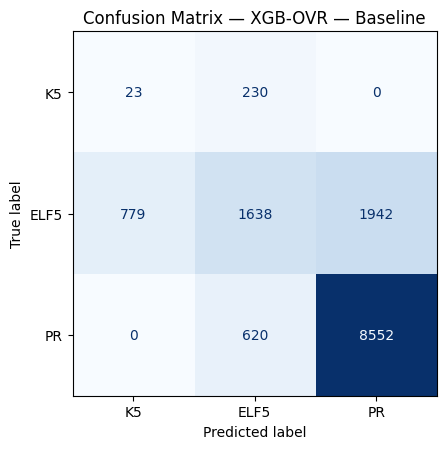

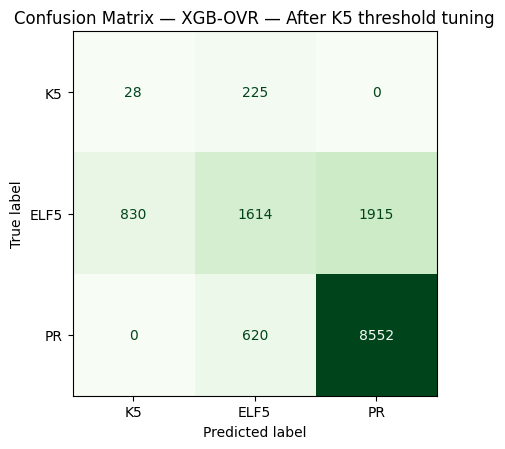

<Figure size 660x480 with 0 Axes>

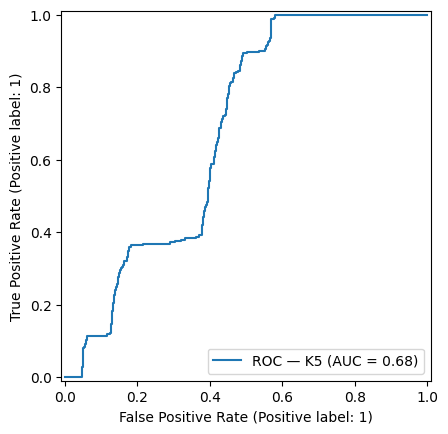

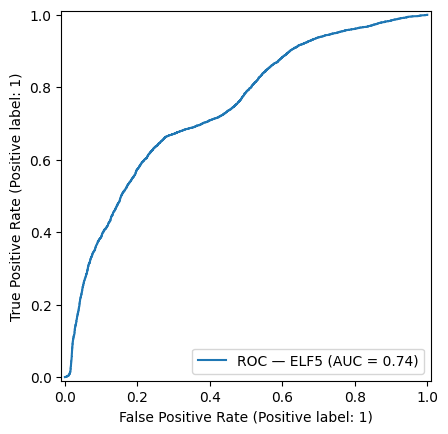

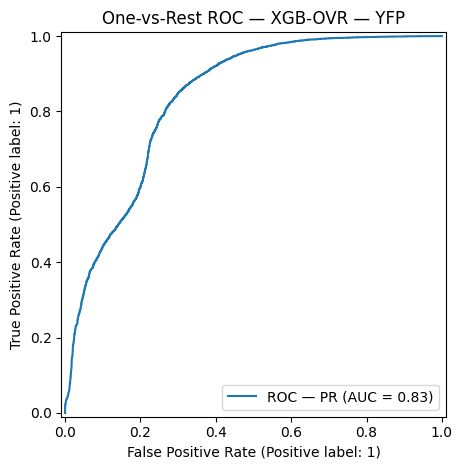

In [ ]:
# ============================
# Cell 5: Visuals (Single-Channel)
#  - Confusion Matrix: baseline vs tuned
#  - ROC (OvR) from probabilities
# ============================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, confusion_matrix
from sklearn.preprocessing import label_binarize

# best_name, y_true_all, proba_all, base_pred, pred_tuned
if "best_name" not in globals():
    best_name = fold_df.groupby("model")["macro_f1"].mean().sort_values(ascending=False).index[0]
if "y_true_all" not in globals() or "proba_all" not in globals() or "base_pred" not in globals():
    y_true_all = np.concatenate([t for (t, p, pr) in fold_preds[best_name]])
    proba_all  = np.vstack([pr for (t, p, pr) in fold_preds[best_name]])
    base_pred  = np.argmax(proba_all, axis=1)

# pred_tuned = base_pred
if "pred_tuned" not in globals():
    pred_tuned = base_pred

labels = np.arange(len(CLASS_NAMES))

# 1) baseline
cm_base = confusion_matrix(y_true_all, base_pred, labels=labels)
fig, ax = plt.subplots(figsize=(5.6,4.6))
ConfusionMatrixDisplay(cm_base, display_labels=CLASS_NAMES).plot(ax=ax, cmap="Blues", colorbar=False)
ax.set_title(f"Confusion Matrix — {best_name} — Baseline")
plt.tight_layout()
plt.show()

# 2) confusion matrix — tuned
cm_tuned = confusion_matrix(y_true_all, pred_tuned, labels=labels)
fig, ax = plt.subplots(figsize=(5.6,4.6))
ConfusionMatrixDisplay(cm_tuned, display_labels=CLASS_NAMES).plot(ax=ax, cmap="Greens", colorbar=False)
ax.set_title(f"Confusion Matrix — {best_name} — After K5 threshold tuning")
plt.tight_layout()
plt.show()

# 3) ROC
Y_bin = label_binarize(y_true_all, classes=labels)
plt.figure(figsize=(6.6,4.8))
for i, name in enumerate(CLASS_NAMES):
    if Y_bin[:, i].sum() == 0:
        continue
    RocCurveDisplay.from_predictions(Y_bin[:, i], proba_all[:, i], name=f"ROC — {name}")
plt.title(f"One-vs-Rest ROC — {best_name} — {CHANNEL_FOR_PRIMARY}")
plt.tight_layout()
plt.show()


[Single-Channel=YFP] shape=(13784, 25), models={'PR': 9172, 'ELF5': 4359, 'K5': 253}, dates=18
Best params (refit on all data): {'model__estimator__subsample': 1.0, 'model__estimator__reg_lambda': 5, 'model__estimator__reg_alpha': 1.0, 'model__estimator__n_estimators': 800, 'model__estimator__max_depth': 5, 'model__estimator__learning_rate': 0.1, 'model__estimator__colsample_bytree': 0.7}


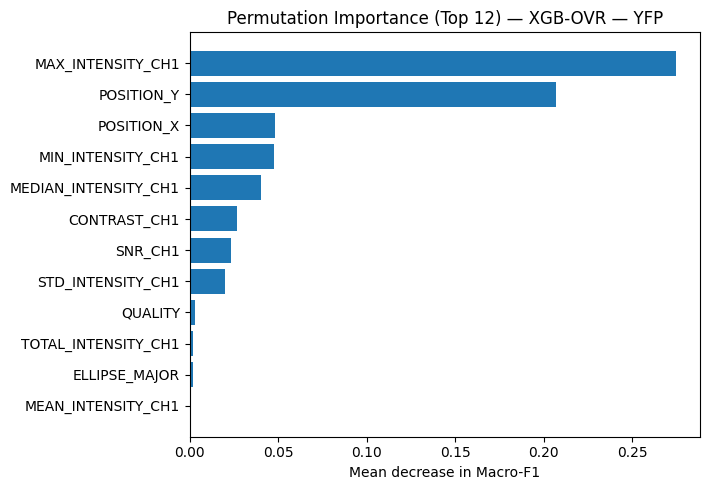

Saved top features to: ..\data\processed\ProblemB\primary_single_YFP_top_features.csv


In [ ]:
# ============================================
# Cell 6: Permutation Importance (Top features)
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut, RandomizedSearchCV
from sklearn.inspection import permutation_importance
from sklearn.utils.class_weight import compute_sample_weight


X_all, y_all, groups_all, num_cols_sc, _ = make_dataset_single_channel(df, channel=CHANNEL_FOR_PRIMARY)
y_all_ids = to_ids(y_all)
inner_groups = pd.to_datetime(groups_all).dt.date
n_inner = min(5, len(np.unique(inner_groups))) if len(np.unique(inner_groups)) >= 3 else len(np.unique(inner_groups))
inner_cv = GroupKFold(n_splits=n_inner) if n_inner >= 3 else LeaveOneGroupOut()


best_name = fold_df.groupby("model")["macro_f1"].mean().sort_values(ascending=False).index[0]
clf, space, is_linear = get_model_spaces(False)[best_name]


pipe = build_pipeline_with_sampler(num_cols_sc, [], clf, is_linear, do_resample=True)

search = RandomizedSearchCV(
    estimator=pipe, param_distributions=space, n_iter=N_SEARCH,
    scoring="f1_macro", cv=inner_cv.split(X_all, y_all_ids, inner_groups),
    n_jobs=-1, random_state=SEED, refit=True, verbose=0
)


fit_kwargs = {"model__sample_weight": compute_sample_weight("balanced", y=y_all_ids)} if best_name in ("LR","RF") else {}
search.fit(X_all, y_all_ids, **fit_kwargs)
best_final = search.best_estimator_
print("Best params (refit on all data):", search.best_params_)


rng_mask = rng.random(len(X_all)) < 0.25
X_hold, y_hold = X_all.iloc[rng_mask], y_all_ids[rng_mask]

pi = permutation_importance(best_final, X_hold, y_hold, scoring="f1_macro",
                            n_repeats=10, random_state=SEED, n_jobs=-1)

pre = best_final.named_steps["pre"]
num_names = list(pre.transformers_[0][2])
feat_imp = pd.DataFrame({"feature": num_names, "importance": pi.importances_mean}).sort_values("importance", ascending=False).head(12)


plt.figure(figsize=(7.2,5.0))
plt.barh(feat_imp["feature"][::-1], feat_imp["importance"][::-1])
plt.xlabel("Mean decrease in Macro-F1")
plt.title(f"Permutation Importance (Top 12) — {best_name} — {CHANNEL_FOR_PRIMARY}")
plt.tight_layout()
plt.show()


imp_path = OUT_DIR / f"primary_single_{CHANNEL_FOR_PRIMARY}_top_features.csv"
feat_imp.to_csv(imp_path, index=False)
print("Saved top features to:", imp_path)


In [ ]:
# ==========================================================
# Cell 7 (FAST): Multi-Channel with CHANNEL as feature
# ==========================================================
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut, RandomizedSearchCV
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
import pandas as pd

# --------- FAST knobs ----------
N_SEARCH_MC = 6           
MAX_INNER_SPLITS_MC = 3    
DO_RESAMPLE_MC = False     
KEEP_MODELS = ("RF", "XGB-OVR") 
# ------------------------------

X_mc, y_mc, groups_mc, num_cols_mc, cat_cols_mc = make_dataset_multi_channel(df)
print(f"[Multi-Channel] shape={X_mc.shape}, models={y_mc.value_counts().to_dict()}, dates={len(pd.unique(groups_mc))}")

outer_cv_mc = make_outer_splitter_strict(to_ids(y_mc), groups_mc, n_splits=5)
models_mc_full = get_model_spaces(for_multi_channel=True)
#  RF / XGB-OVR
models_mc = {k:v for k,v in models_mc_full.items() if k in KEEP_MODELS}


def shrink_space(space):
    small = {}
    for k, v in space.items():
        if isinstance(v, (list, tuple)):
            if len(v) <= 3:
                small[k] = list(v)
            else:
                
                mid = v[len(v)//2]
                small[k] = [v[0], mid, v[-1]]
        else:
            small[k] = v
    
    if "model__n_estimators" in small: small["model__n_estimators"] = [200]
    if "model__estimator__n_estimators" in small: small["model__estimator__n_estimators"] = [200]
    if "model__estimator__learning_rate" in small: small["model__estimator__learning_rate"] = [0.1]
    if "model__estimator__max_depth" in small: small["model__estimator__max_depth"] = [5]
    if "model__estimator__subsample" in small: small["model__estimator__subsample"] = [0.9]
    if "model__estimator__colsample_bytree" in small: small["model__estimator__colsample_bytree"] = [0.9]
    return small

fold_scores_mc = {name: [] for name in models_mc.keys()}

def make_local_maps(y_ids):
    present = np.sort(np.unique(y_ids))
    g2l = {g:i for i,g in enumerate(present)}
    l2g = {i:g for i,g in enumerate(present)}
    return present, g2l, l2g

fold_idx = 0
for train_idx, test_idx in outer_cv_mc.split(X_mc, y_mc, groups_mc):
    fold_idx += 1
    X_tr, X_te = X_mc.iloc[train_idx], X_mc.iloc[test_idx]
    y_tr_g, y_te_g = to_ids(y_mc.iloc[train_idx]), to_ids(y_mc.iloc[test_idx])
    g_tr = pd.Series(groups_mc).iloc[train_idx]

    present, g2l, l2g = make_local_maps(y_tr_g)
    y_tr = np.array([g2l[v] for v in y_tr_g], dtype="int32")
    w_tr = compute_sample_weight(class_weight="balanced", y=y_tr_g)

    inner_groups = pd.to_datetime(g_tr).dt.date
    n_unique = len(np.unique(inner_groups))
    n_inner = min(MAX_INNER_SPLITS_MC, n_unique) if n_unique >= 3 else n_unique
    inner_cv = GroupKFold(n_splits=n_inner) if n_inner >= 3 else LeaveOneGroupOut()

    print(f"\n===== Multi Fold {fold_idx} | Train={len(X_tr)} Test={len(X_te)} | inner splits={n_inner} =====")
    for name, (clf, space, is_linear) in models_mc.items():
        
        space_small = shrink_space(space)
        
        pipe = build_pipeline_with_sampler(num_cols_mc, cat_cols_mc, clf, is_linear, do_resample=DO_RESAMPLE_MC)

        search = RandomizedSearchCV(
            estimator=pipe,
            param_distributions=space_small,
            n_iter=N_SEARCH_MC,
            scoring="f1_macro",
            cv=inner_cv.split(X_tr, y_tr, inner_groups),
            n_jobs=-1, random_state=SEED, refit=True, verbose=0, error_score="raise",
        )
        
        fit_kwargs = {"model__sample_weight": w_tr} if name in ("LR","RF") else {}
        search.fit(X_tr, y_tr, **fit_kwargs)

        y_pred_local  = search.best_estimator_.predict(X_te)
        y_pred_global = np.array([l2g[i] for i in y_pred_local], dtype="int32")
        proba_local   = search.best_estimator_.predict_proba(X_te)
        y_proba       = align_proba(proba_local, est_classes=present, n_classes=N_CLASSES)

        m_f1 = f1_score(y_te_g, y_pred_global, average="macro")
        acc  = accuracy_score(y_te_g, y_pred_global)
        auc  = safe_macro_auc(y_te_g, y_proba)

        fold_scores_mc[name].append((m_f1, acc, auc))
        print(f"{name}: MacroF1={m_f1:.3f} Acc={acc:.3f} AUC={('nan' if np.isnan(auc) else f'{auc:.3f}')}")

# save
rows = []
for name, lst in fold_scores_mc.items():
    for i, (m_f1, acc, auc) in enumerate(lst, 1):
        rows.append({"model": name, "fold": i, "macro_f1": m_f1, "accuracy": acc, "macro_auc": auc})
fold_df_mc = pd.DataFrame(rows)
fold_path_mc = OUT_DIR / "supplement_multi_channel_fold_scores_fast.csv"
fold_df_mc.to_csv(fold_path_mc, index=False)
print("\nSaved multi-channel per-fold scores to:", fold_path_mc)

leader_mc = (fold_df_mc.groupby("model")[["macro_f1","accuracy","macro_auc"]]
             .agg(["mean","std"]).round(3))
print("\n=== Leaderboard (mean±std) — Multi-Channel (FAST) ===\n")
display(leader_mc)


[Multi-Channel] shape=(56049, 26), models={'PR': 42842, 'ELF5': 11320, 'K5': 1887}, dates=22
[Multi-Channel] shape=(56049, 26), models={'PR': 42842, 'ELF5': 11320, 'K5': 1887}, dates=22

===== Multi Fold 1 | Train=49013 Test=7036 | inner splits=3 =====
RF: MacroF1=0.491 Acc=0.878 AUC=0.974
XGB-OVR: MacroF1=0.513 Acc=0.885 AUC=0.945

===== Multi Fold 2 | Train=44406 Test=11643 | inner splits=3 =====
RF: MacroF1=0.400 Acc=0.797 AUC=0.763
XGB-OVR: MacroF1=0.448 Acc=0.877 AUC=0.811

===== Multi Fold 3 | Train=50202 Test=5847 | inner splits=3 =====
RF: MacroF1=0.493 Acc=0.971 AUC=nan
XGB-OVR: MacroF1=0.492 Acc=0.968 AUC=nan

===== Multi Fold 4 | Train=39093 Test=16956 | inner splits=3 =====
RF: MacroF1=0.199 Acc=0.376 AUC=0.418
XGB-OVR: MacroF1=0.191 Acc=0.367 AUC=0.344

===== Multi Fold 5 | Train=41482 Test=14567 | inner splits=3 =====
RF: MacroF1=0.399 Acc=0.426 AUC=0.862
XGB-OVR: MacroF1=0.494 Acc=0.441 AUC=0.878

Saved multi-channel per-fold scores to: ..\data\processed\ProblemB\supplem

macro_f1        accuracy        macro_auc       
            mean    std     mean    std      mean    std
model                                                   
RF         0.396  0.120    0.690  0.271     0.754  0.240
XGB-OVR    0.428  0.134    0.708  0.280     0.744  0.273

In [ ]:
# =====================================
# Cell 8: Statistical comparisons
#  - Wilcoxon pairwise tests (Macro-F1)
#  - Single vs Multi best model comparison
# =====================================
from scipy.stats import wilcoxon
import numpy as np

def pairwise_wilcoxon(fold_df, model_a, model_b):
    a = fold_df[fold_df["model"]==model_a].sort_values("fold")["macro_f1"].values
    b = fold_df[fold_df["model"]==model_b].sort_values("fold")["macro_f1"].values
    n = min(len(a), len(b))
    if n < 2:
        return np.nan
    stat, p = wilcoxon(a[:n], b[:n], zero_method="wilcox")
    return p

def show_pairs(fold_df, title):
    models = fold_df["model"].unique().tolist()
    print(title)
    for i in range(len(models)):
        for j in range(i+1, len(models)):
            p = pairwise_wilcoxon(fold_df, models[i], models[j])
            print(f"  {models[i]} vs {models[j]}: p = {p:.4f}")

print("\n-- Single-Channel (YFP) model comparison --")
show_pairs(fold_df, "Pairwise Wilcoxon p-values (Macro-F1):")

if "fold_df_mc" in globals():
    print("\n-- Multi-Channel model comparison --")
    show_pairs(fold_df_mc, "Pairwise Wilcoxon p-values (Macro-F1):")

    
    best_sc = fold_df.groupby("model")["macro_f1"].mean().sort_values(ascending=False).index[0]
    best_mc = fold_df_mc.groupby("model")["macro_f1"].mean().sort_values(ascending=False).index[0]
    sc_vals = fold_df[fold_df["model"]==best_sc].sort_values("fold")["macro_f1"].values
    mc_vals = fold_df_mc[fold_df_mc["model"]==best_mc].sort_values("fold")["macro_f1"].values
    n = min(len(sc_vals), len(mc_vals))
    if n >= 2:
        stat, p = wilcoxon(sc_vals[:n], mc_vals[:n], zero_method="wilcox")
        print(f"\nBest Single ({best_sc}) vs Best Multi ({best_mc}) — Wilcoxon p={p:.4f}")
    else:
        print("\nNot enough folds overlapped to compare single vs multi.")
else:
    print("\n(You haven't run Cell 7 yet; skip single vs multi comparison.)")



-- Single-Channel (YFP) model comparison --
Pairwise Wilcoxon p-values (Macro-F1):
  LR vs RF: p = 0.8125
  LR vs XGB-OVR: p = 0.8125
  RF vs XGB-OVR: p = 0.6250

-- Multi-Channel model comparison --
Pairwise Wilcoxon p-values (Macro-F1):
  RF vs XGB-OVR: p = 0.3125

Best Single (XGB-OVR) vs Best Multi (XGB-OVR) — Wilcoxon p=0.3125
